# Present data for report

- Select results to show for 2021
- Merge results from 2020 where relevant, e.g. for pre-2000 data trends using lower resolution
- Figure out relevant visualisation focusing on inequality topic for 2021 report - especially wrt HDI class trends
- TODO decide what parameters you actually keep - don't need to lug around every indicator! e.g. focus on heawave counts and days totals
- Extract single values where needed, e.g. baseline HW numbers (**they always ask this**)


>  TODO incorporate inequalities/HDI work => maybe a plot with hdi vs heatwave change like what i did for the other paper -> note that this means using country agg data not hdi agg.

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from cartopy import crs as ccrs
from scipy import stats

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

In [3]:
# Figure settings
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [4]:
MAX_YEAR = 2020
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('../results/heatwaves/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2021'
SD_FOLDER = Path('~').expanduser() / 'Documents' / 'Lancet'/ 'Standardisation guidelines - LIVE FOR AUTHORS'
COUNTRY_SHAPEFILE = SD_FOLDER / 'Shapefiles' / 'detailed_2013.shp'

COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

In [5]:
MAP_PROJECTION = ccrs.EckertIII()

In [6]:
MIN_YEAR = 1980

In [7]:
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

## Load basic country data

In [8]:
countries = gpd.read_file(COUNTRY_SHAPEFILE)

In [9]:
country_classification = pd.read_excel(SD_FOLDER / 'Country names - ISO3 codes - WHO and HDI classifications2021.xlsx', skiprows=1)

countries = countries.set_index('ISO_3_CODE')

countries = countries.join(country_classification.set_index('ISO ALPHA-3 code'))

countries.index.name = 'country'

<AxesSubplot:>

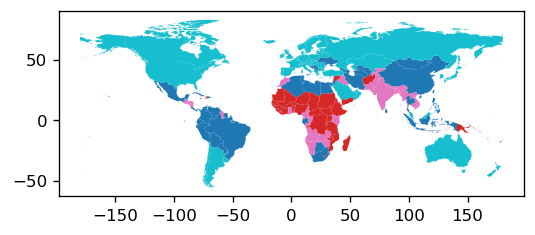

In [10]:
countries.plot(column='Level of human development')

In [11]:
un_pop_totals = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2019_TotalPopulationBySex.csv')
un_pop_totals = un_pop_totals[un_pop_totals.VarID == 2] # medium variant 

un_pop_totals = un_pop_totals.set_index('LocID').join(COUNTRIES_LOOKUP.set_index('UNSDCODE')['ISOCODE'])

un_pop_totals = un_pop_totals[~pd.isna(un_pop_totals.ISOCODE)]

In [12]:
un_pop_totals_xr = un_pop_totals[['ISOCODE', 'Time', 'PopTotal']].set_index(['ISOCODE', 'Time']).sort_index().to_xarray()

un_pop_totals_xr = un_pop_totals_xr.rename({'Time': 'year', 'ISOCODE': 'country'}).PopTotal

## Load exposure results

In [12]:
exposures_over65 = xr.open_dataset(
    INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_multi_threshold_1980-{MAX_YEAR}.nc')

total_exposure_count = exposures_over65.heatwaves_counts.sum(dim=['latitude', 'longitude']).to_dataframe('exposures')
total_exposure_days = exposures_over65.heatwaves_days.sum(dim=['latitude', 'longitude']).to_dataframe('exposures')

In [13]:
total_exposure_days.loc[2020]

exposures    3.065450e+09
Name: 2020, dtype: float64

In [14]:
total_exposure_count.loc[2020]

exposures    5.818833e+08
Name: 2020, dtype: float64

In [15]:
total_exposures_over65 = pd.read_excel(RESULTS_FOLDER / 'heatwave_exposure_indicator_totals_over65.xlsx').set_index('year')

### Also load infants

In [16]:
exposures_infants = xr.open_dataset(
    INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_infants_multi_threshold_{MIN_YEAR}-{MAX_YEAR}.nc')


In [17]:
total_exposures_infants = pd.read_excel(RESULTS_FOLDER / 'heatwave_exposure_indicator_totals_infants.xlsx').set_index('year')

## Load weighted results

In [18]:
weighted_metrics_over65 = pd.read_excel(RESULTS_FOLDER / 'heatwave_metrics_weighted_mean_over65.xlsx').set_index('year')

weighted_metrics_infants = pd.read_excel(RESULTS_FOLDER / 'heatwave_metrics_weighted_infants.xlsx').set_index('year')

## Load the country exposure results

In [22]:
country_exposure = xr.open_dataset(
    INTERMEDIATE_RESULTS_FOLDER / f'countries_heatwaves_exposure_change_{MIN_YEAR}-{MAX_YEAR}.nc')

In [43]:
# country_exposure[ 'heatwaves_days'].to_dataframe()

### Infants

In [15]:
country_exposure_infants = xr.open_dataset(
    INTERMEDIATE_RESULTS_FOLDER / f'countries_heatwaves_exposure_change_infants_{MIN_YEAR}-{MAX_YEAR}.nc')

## Calculate values normalised by TOTAL population to make it easy to compare the different vuln groups

In [24]:
country_exposure_over65_absnorm = country_exposure.squeeze() / un_pop_totals_xr

In [25]:
country_exposure_infants_absnorm = country_exposure_infants / un_pop_totals_xr

In [26]:
country_exposure_infants_absnorm

<xarray.Dataset>
Dimensions:               (country: 231, year: 41)
Coordinates:
  * country               (country) object 'AFG' 'ALB' 'DZA' ... 'YEM' 'ZMB'
  * year                  (year) int64 1980 1981 1982 1983 ... 2018 2019 2020
    age_band_lower_bound  int32 0
Data variables:
    heatwave_mean_length  (country, year) float64 -15.91 7.91 ... 49.86 -8.11
    heatwaves_counts      (country, year) float64 -10.69 0.2594 ... 52.54 39.34
    heatwaves_days        (country, year) float64 -71.73 0.6703 ... 333.5 166.4

## Load country weighted mean heatwave

In [27]:
country_weighted = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'countries_heatwaves_exposure_weighted_change_{MIN_YEAR}-{MAX_YEAR}.nc')

In [28]:
# Create DF merging the country normalised data with the country data
cw_df = country_weighted.heatwaves_days.to_dataframe().heatwaves_days.unstack()

cw_df = countries.join(cw_df)

cw_df = cw_df.join(country_weighted[ 'heatwaves_days'].sel(year=slice(2000,2020)).mean(dim='year').to_dataframe())

## Load aggregated by hdi and WHO region data

In [29]:
hdi_exposure = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'hdi_regions_heatwaves_exposure_change_{MIN_YEAR}-{MAX_YEAR}.nc')

who_exposure = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'who_regions_heatwaves_exposure_change_{MIN_YEAR}-{MAX_YEAR}.nc')

In [13]:
hdi_exposure_infants = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'infants_hdi_regions_heatwaves_exposure_change_{MIN_YEAR}-{MAX_YEAR}.nc')

who_exposure_infants = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'infants_who_regions_heatwaves_exposure_change_{MIN_YEAR}-{MAX_YEAR}.nc')

## Load heatwave metrics files

In [32]:
# heatwave_counts
# INTERMEDIATE_RESULTS_FOLDER / f'heatwaves_counts_single_threshold_1980-{MAX_YEAR}.nc',

heatwave_metrics_files = [
    f'heatwaves_counts_multi_threshold_1980-{MAX_YEAR}.nc', 
    f'heatwaves_days_multi_threshold_1980-{MAX_YEAR}.nc', 
    f'heatwave_mean_length_multi_threshold_1980-{MAX_YEAR}.nc'
                         ]

heatwave_metrics_files = [
    INTERMEDIATE_RESULTS_FOLDER / f 
    for f in heatwave_metrics_files
]
heatwave_metrics = xr.open_mfdataset(heatwave_metrics_files, combine='by_coords')
heatwaves_metrics_reference = heatwave_metrics.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwave_metrics_delta = heatwave_metrics - heatwaves_metrics_reference

In [33]:
heatwave_days_2020_method = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'heatwaves_days_single_threshold_1980-{MAX_YEAR}.nc')
heatwaves_days_reference_2020 = heatwave_days_2020_method.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwave_days_delta_2020 = heatwave_days_2020_method - heatwaves_days_reference_2020

In [34]:
hwd_mean = heatwave_metrics_delta.heatwaves_days.mean(dim=['latitude', 'longitude'])

hwd_mean_2020 = heatwave_days_delta_2020.heatwaves_days.mean(dim=['latitude', 'longitude'])

# Re-export data tables as csv

In [58]:
country_exposure.heatwaves_days.to_dataframe().to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_country.csv')

hdi_exposure.heatwaves_days.to_dataframe().to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_hdi.csv')
who_exposure.heatwaves_days.to_dataframe().to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_who_region.csv')

In [23]:
(country_exposure_infants
 .heatwaves_days.drop('age_band_lower_bound')
 .to_dataframe()
 .reset_index()
 .to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_country_infants.csv', index=False))

In [21]:
# country_exposure.heatwaves_days.to_dataframe().to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_country.csv')

(hdi_exposure_infants
 .heatwaves_days
 .drop('age_band_lower_bound')
 .to_dataframe()
 .reset_index()
 .to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_infants_by_hdi.csv', index=False))
(who_exposure_infants
.heatwaves_days
 .drop('age_band_lower_bound')
 .to_dataframe()
 .reset_index()
 .to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_infants_by_who_region.csv', index=False))


### Create country table with the WHO and HDI region columns

In [36]:
# Create DF merging the country total data with the country data

ce_df = country_exposure.heatwaves_days.to_dataframe()[['heatwaves_days']]

In [42]:
ce_df = (ce_df
         .reset_index()
         .set_index('country')
         .join(
             countries[['WHO_REGION','WHO Region', 'Level of human development', 'Human Development Index in 2018 (HDI)']]
         )
        )

In [46]:
ce_df.to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_country_over65_w_hdi_who.csv')

In [44]:
# Create DF merging the country total data with the country data

ce_i_df = country_exposure_infants.heatwaves_days.to_dataframe().heatwaves_days.unstack()

In [45]:
ce_i_df = (ce_i_df
         .reset_index()
         .set_index('country')
         .join(
             countries[['WHO_REGION','WHO Region', 'Level of human development', 'Human Development Index in 2018 (HDI)']]
         )
        )

In [47]:
ce_i_df.to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_country_infants_w_hdi_who.csv')

# Plots

## Plot heatwaves

Plot the number of heatwaves time series with the new and old methods -> use for appendix

### Compare the 2021 and 2020 heatwave number of days

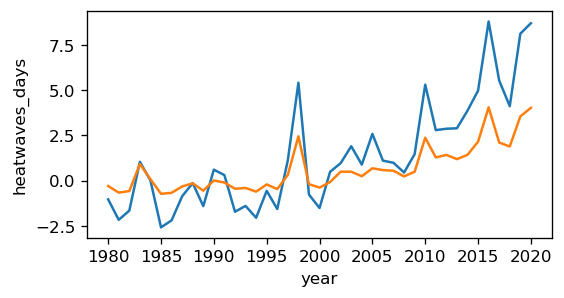

In [39]:
hwd_mean.plot()
hwd_mean_2020.plot()

## Plot exposures

**NOTE** Some of this is already saved out automatically in the data gen notebook

> Plot exposures combining the 1980-2000 values calculated using histsoc with the 2000-2020 values. Highlight that the data sources are different

In [56]:
# with sns.axes_style("whitegrid"):
#     f, ax = plt.subplots()

#     (total_exposure_count.exposures / 1e6).loc[2000:].plot(ax=ax, label='GPWv4')
#     (total_exposure_count.exposures / 1e6).loc[:1999].plot(style=':', label='ISIMIP', ax=ax)
#     ax.legend()
#     ax.set_ylabel('Million events')
    
    

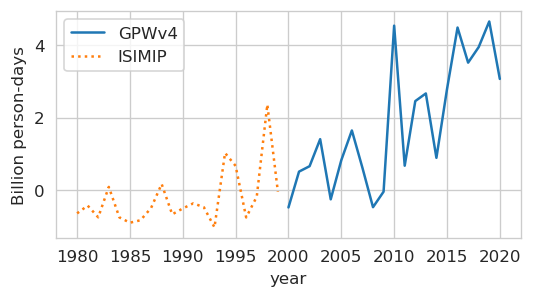

In [58]:
with sns.axes_style("whitegrid"):
    var = 'heatwaves_days'

    f, ax = plt.subplots()

    (total_exposures_over65[var] / 1e9).loc[2000:].plot(ax=ax, label='GPWv4')
    (total_exposures_over65[var] / 1e9).loc[:1999].plot(style=':', label='ISIMIP', ax=ax)
    ax.legend()
    ax.set_ylabel('Billion person-days')
    f.savefig(RESULTS_FOLDER / 'heatwave person-days hybrid 1980-2020.png')
    f.savefig(RESULTS_FOLDER / 'heatwave person-days hybrid 1980-2020.pdf')
    
    

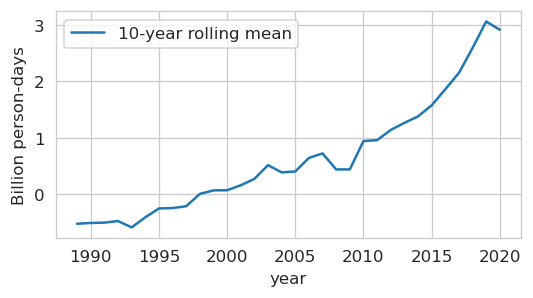

In [61]:
plot_data  = (total_exposures_over65[var] / 1e9).rolling(10).mean()
with sns.axes_style("whitegrid"):
    var = 'heatwaves_days'

    f, ax = plt.subplots()

    plot_data.plot(ax=ax, label='10-year rolling mean')
#     (total_exposures_over65[var] / 1e9).loc[:1999].rolling(10).mean().plot(style=':', label='ISIMIP', ax=ax)
    ax.legend()
    ax.set_ylabel('Billion person-days')
#     f.savefig(RESULTS_FOLDER / 'heatwave person-days hybrid 1980-2020.png')
#     f.savefig(RESULTS_FOLDER / 'heatwave person-days hybrid 1980-2020.pdf')
    
    

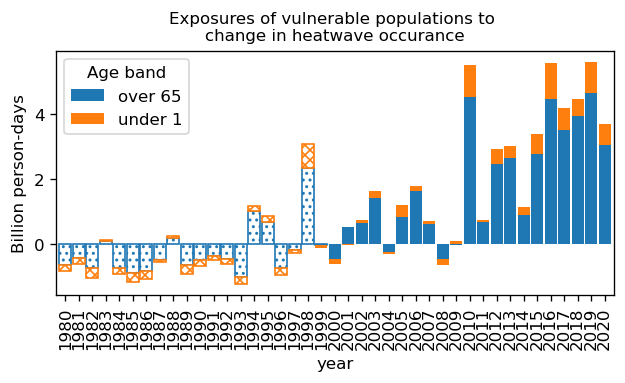

In [67]:

f , ax = plt.subplots(figsize=(6,2.7))
plot_data = pd.concat([total_exposures_over65.heatwaves_days, total_exposures_newborns.heatwaves_days], axis=1) / 1e9
plot_data.columns = ['over 65', 'under 1']
ax = plot_data.plot.bar(stacked=True, width=0.89, ax=ax)
ax.set_ylabel('Billion person-days')
ax.set_title('Exposures of vulnerable populations to \nchange in heatwave occurance')
ax.legend(title='Age band')

for p in ax.patches[:20]:
    p.set_hatch('...')
    p.set_edgecolor('C0')
    p.set_facecolor('w')

for p in ax.patches[41:60]:
    p.set_hatch('xxxx')
    p.set_edgecolor('C1')
    p.set_facecolor('w')

plt.savefig(RESULTS_FOLDER / 'heatwave person-days hybrid w newborn 1980-2020.png')
plt.savefig(RESULTS_FOLDER / 'heatwave person-days hybrid w newborn 1980-2020.pdf')

In [44]:
# total_exposures_newborns.heatwaves_days / 1e6

In [40]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [37]:
_namelookup = COUNTRIES_LOOKUP.set_index('ISOCODE').NAME0.to_dict()
_namelookup['Other'] = 'Rest of World'

In [38]:
c = sns.color_palette("Paired")

In [39]:
consistent_colors = dict(zip(
    ['CHN', 'EGY', 'IDN', 'IND', 'JPN', 'NGA', 'Other', 'USA'],
    [c[5], c[6],   c[7], c[3], c[8], c[11], c[0], c[1] ]
))

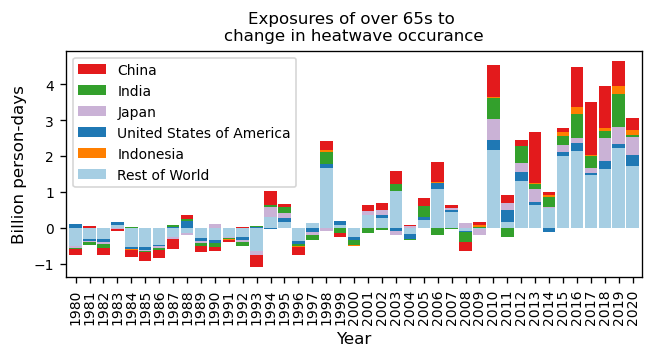

In [49]:
var = 'heatwaves_days'
# Sort and show the top 5 for a given year
top_codes = country_exposure[var].sel(year=slice(2015,2020)).mean(dim='year').to_dataframe().sort_values(by=var, ascending=False).head(5)[var].index.to_list()

results = country_exposure[var].sel(country=top_codes).to_dataframe()[var].unstack().T
# Difference between sum of top5 countries and total gives the 'other' category
results['Other'] = total_exposures_over65[var] - results.sum(axis=1)
# invert column order
results = results[results.columns[::-1]]

f, ax = plt.subplots(figsize=(6.2, 2.5))
(results / 1e9).plot.bar(stacked=True, 
                         width=0.9, 
                         ax=ax,
                         color=consistent_colors
                        )

ax.set(
    xlabel='Year',
    ylabel='Billion person-days',
    title='Exposures of over 65s to \nchange in heatwave occurance',
)
ax.xaxis.set_tick_params(labelsize='small')
ax.yaxis.set_tick_params(labelsize='small')

# Manually order the legend
handles, labels = ax.get_legend_handles_labels()
d = dict(zip(labels, handles))
iso_codes = ['CHN', 'IND', 'JPN', 'USA', 'IDN', 'Other']


ordered_handles = [d[l] for l in iso_codes]
ordered_labels = [_namelookup[l] for l in iso_codes]

ordered_handles = [d[l] for l in iso_codes]
ax.legend(ordered_handles, ordered_labels, fontsize='small')

f.savefig(RESULTS_FOLDER / f'hw_exposure_over65_countries_1980-{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER / f'hw_exposure_over65_countries_1980-{MAX_YEAR}.pdf')


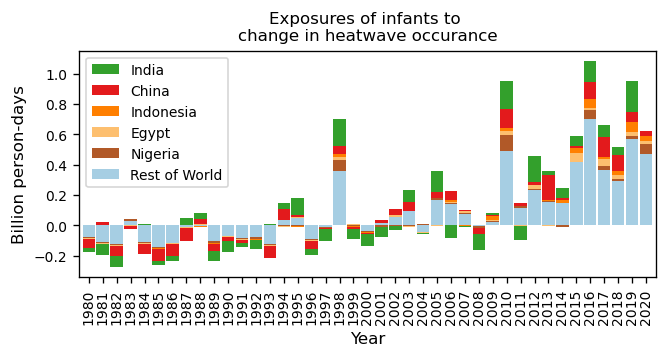

In [41]:
var = 'heatwaves_days'
# Sort and show the top 5 for a given year
top_codes = country_exposure_infants[var].sel(year=slice(2015,2020)).mean(dim='year').to_dataframe().sort_values(by=var, ascending=False).head(5)[var].index.to_list()

results = country_exposure_infants[var].sel(country=top_codes).to_dataframe()[var].unstack().T
# Difference between sum of top5 countries and total gives the 'other' category
results['Other'] = total_exposures_infants[var] - results.sum(axis=1)
# invert column order
results = results[results.columns[::-1]]

f, ax = plt.subplots(figsize=(6.2, 2.5))
(results / 1e9).plot.bar(stacked=True,
                         width=0.9, 
                         ax=ax,
                         color=consistent_colors
                        )

ax.set(
    xlabel='Year',
    ylabel='Billion person-days',
    title='Exposures of infants to \nchange in heatwave occurance',
)
ax.xaxis.set_tick_params(labelsize='small')
ax.yaxis.set_tick_params(labelsize='small')

# Manually order the legend
handles, labels = ax.get_legend_handles_labels()
d = dict(zip(labels, handles))
iso_codes = ['IND','CHN', 'IDN',  'EGY', 'NGA', 'Other']

ordered_handles = [d[l] for l in iso_codes]
ordered_labels = [_namelookup[l] for l in iso_codes]

ax.legend(ordered_handles, ordered_labels, fontsize='small')

f.savefig(RESULTS_FOLDER / f'hw_exposure_infants_countries_1980-{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER / f'hw_exposure_infants_countries_1980-{MAX_YEAR}.pdf')


In [52]:
country_exposure_allages = country_exposure + country_exposure_infants.drop('age_band_lower_bound')

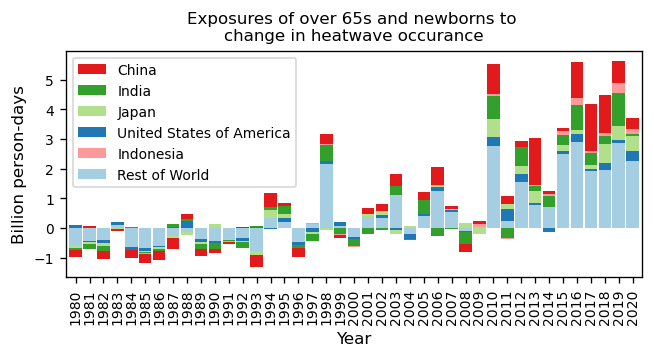

In [55]:
var = 'heatwaves_days'
# Sort and show the top 5 for a given year
top_codes = country_exposure_allages[var].sel(year=slice(2015,2020)).mean(dim='year').to_dataframe().sort_values(by=var, ascending=False).head(5)[var].index.to_list()

results = country_exposure_allages[var].sel(country=top_codes).to_dataframe()[var].unstack().T
# Difference between sum of top5 countries and total gives the 'other' category
results['Other'] = (total_exposures_over65[var] + total_exposures_newborns[var] ) - results.sum(axis=1)
# invert column order
results = results[results.columns[::-1]]

with sns.color_palette("Paired"):
    f, ax = plt.subplots(figsize=(6.2, 2.5))
    (results / 1e9).plot.bar(stacked=True, 
                                  width=0.9, 
                             ax=ax
                            )
    
    ax.set(
        xlabel='Year',
        ylabel='Billion person-days',
        title='Exposures of over 65s and newborns to \nchange in heatwave occurance',
    )
    ax.xaxis.set_tick_params(labelsize='small')
    ax.yaxis.set_tick_params(labelsize='small')
    
    # Manually order the legend
    handles, labels = ax.get_legend_handles_labels()
    d = dict(zip(labels, handles))
    iso_codes = ['CHN', 'IND', 'JPN', 'USA', 'IDN', 'Other']

    ordered_handles = [d[l] for l in iso_codes]
    ordered_labels = [_namelookup[l] for l in iso_codes]
    
    ax.legend(ordered_handles, ordered_labels, fontsize='small')

    f.savefig(RESULTS_FOLDER / f'hw_exposure_over65_newborn_countries_1980-{MAX_YEAR}.png')
    f.savefig(RESULTS_FOLDER / f'hw_exposure_over65_newborn_countries_1980-{MAX_YEAR}.pdf')


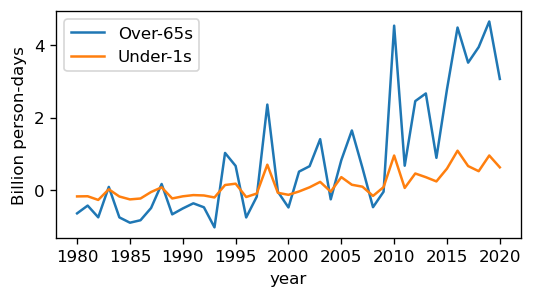

In [46]:
(total_exposures_over65.heatwaves_days / 1e9).plot(label='Over-65s')
ax = (total_exposures_infants.heatwaves_days/ 1e9).plot(label='Under-1s')
ax.set_ylabel('Billion person-days')
ax.legend()
plt.savefig(RESULTS_FOLDER / 'old newborn time series.png')
plt.savefig(RESULTS_FOLDER / 'old newborn time series.pdf')

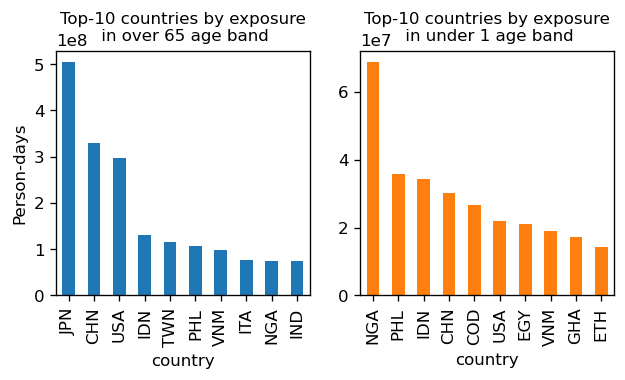

In [47]:
f, axs = plt.subplots(1,2, figsize=(6,2.7), sharey=False)
var = 'heatwaves_days'
ax = axs[0]
# Sort and show the top 5 for a given year
(country_exposure[var]
 .sel(year=MAX_YEAR)
 .to_dataframe()
 .sort_values(by=var, ascending=False)
 .head(10)[var]
 .plot
 .bar(ax=ax
     )
)
ax.set(ylabel='Person-days',
       title='Top-10 countries by exposure\n in over 65 age band'
      )
var = 'heatwaves_days'
ax = axs[1]
# Sort and show the top 5 for a given year
(country_exposure_infants[var]
 .sel(year=MAX_YEAR)
 .to_dataframe()
 .sort_values(by=var, ascending=False)
 .head(10)[var]
 .plot
 .bar(ax=ax,
      color='C1'
     )
)
ax.set(
       title='Top-10 countries by exposure\n in under 1 age band'
      )

plt.savefig(RESULTS_FOLDER / 'top 10 countires comp.png')

In [83]:
t = (country_exposure_newborn[var]
 .sel(year=MAX_YEAR)
 .to_dataframe()
      .sort_values(by=var, ascending=False)
    )

In [85]:
t.heatwaves_days['NGA'] / t.heatwaves_days.sum()

0.11279969288083792

### Compare wieghted trends 65 and infants

because over 65 band is much wider need to adjust for the relative number of humans in each band

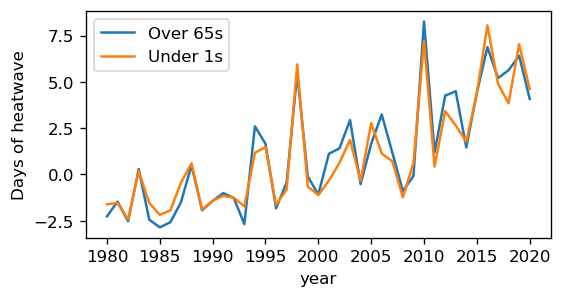

In [48]:
weighted_metrics_over65.heatwaves_days.plot(label='Over 65s')
ax = weighted_metrics_infants.heatwaves_days.plot(label='Under 1s')
ax.legend()
ax.set(ylabel='Days of heatwave',
      )
plt.savefig(RESULTS_FOLDER / 'hw_weighted_old_young.png')
plt.savefig(RESULTS_FOLDER / 'hw_weighted_old_young.pdf')

## Plot relation between heatwave exposures and HDI

Aim is to tell a story about inequality and climate change

> TODO would like to also show non-pop wieghted heatwaves by HDI ->> to see if there is a trend of high heatwaves for low income but those countries have young population

In [18]:
# plot_data = country_weighted.heatwaves_days.to_dataframe()

Text(44.754539609053474, 0.5, 'Exposure weighted change in heatwaves [N]')

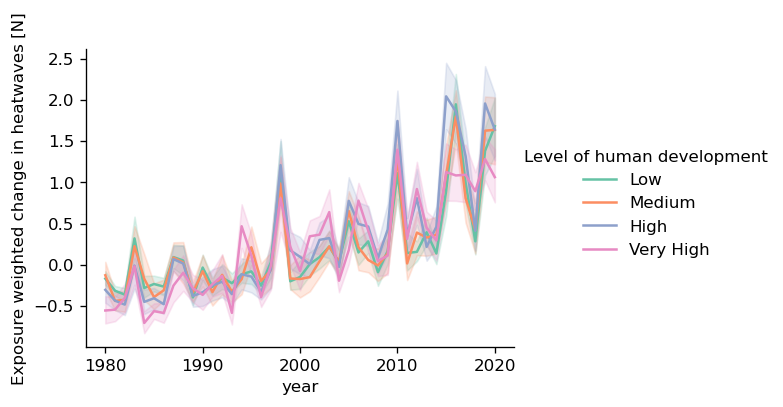

In [71]:
plot_data = (country_weighted
             .heatwaves_counts
             .to_dataframe()
             .unstack()
             .heatwaves_counts
             .join(countries[['Level of human development']])
             .reset_index()
             .set_index(['Level of human development','country'])
             .stack()
             .to_frame('heatwaves_counts')
             .reset_index()
             .rename(columns={'level_2':'year'})
            )

g = sns.relplot(kind='line', 
            data=plot_data, x='year', y='heatwaves_counts', 
            hue='Level of human development', 
            palette='Set2',
                height=3, aspect=4.5/3
           )

g.axes[0][0].set_ylabel('Exposure weighted change in heatwaves [N]')

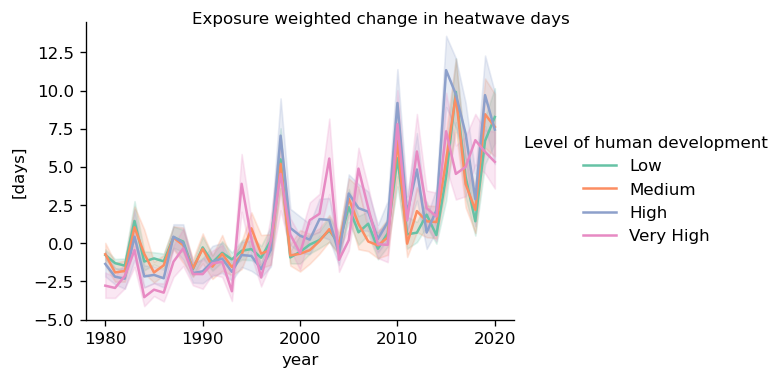

In [72]:
plot_data = (country_weighted
             .heatwaves_days
             .to_dataframe()
             .unstack()
             .heatwaves_days
             .join(countries[['Level of human development']])
             .reset_index()
             .set_index(['Level of human development','country'])
             .stack()
             .to_frame('heatwaves_days')
             .reset_index()
             .rename(columns={'level_2':'year'})
            )

g = sns.relplot(kind='line', 
            data=plot_data, x='year', y='heatwaves_days', 
            hue='Level of human development', 
            palette='Set2',
            height=3, aspect=4.5/3
           )

g.axes[0][0].set_ylabel('[days]')
g.fig.suptitle('Exposure weighted change in heatwave days')
g.fig.savefig(RESULTS_FOLDER / 'exposure weighted by hdi.png')
g.fig.savefig(RESULTS_FOLDER / 'exposure weighted by hdi.pdf')

Text(41.41241898148146, 0.5, 'Exposure to change in heatwaves [days]')

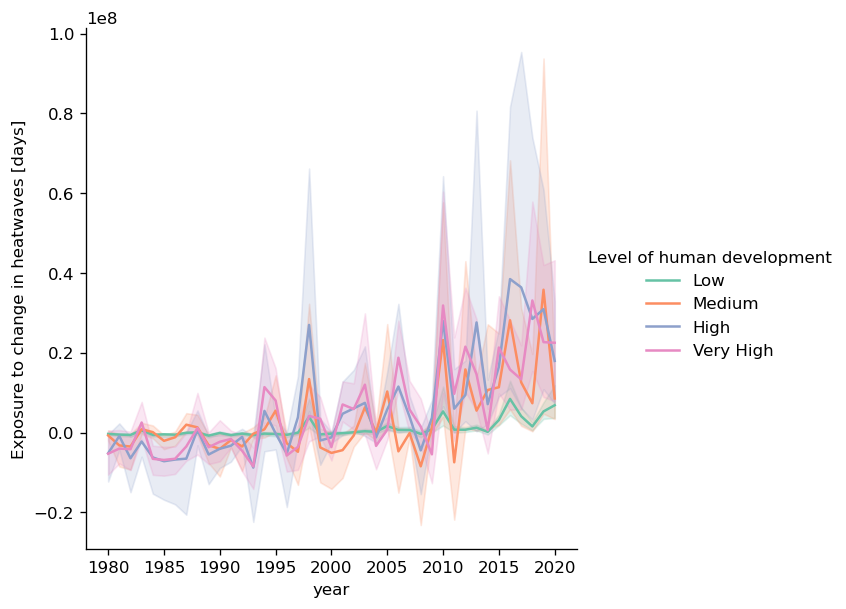

In [56]:
plot_data = (country_exposure
             .heatwaves_days
             .to_dataframe()
             .unstack()
             .heatwaves_days
             .join(countries[['Level of human development']])
             .reset_index()
             .set_index(['Level of human development','country'])
             .stack()
             .to_frame('heatwaves_days')
             .reset_index()
             .rename(columns={'level_2':'year'})
            )

g = sns.relplot(kind='line', 
            data=plot_data, x='year', y='heatwaves_days', 
            hue='Level of human development', 
            palette='Set2'
           )

g.axes[0][0].set_ylabel('Exposure to change in heatwaves [days]')

# Dimensions of vulnerability - newborns vs old age, plot with HDI

In [38]:
ce_norm_65_df =  country_exposure_over65_absnorm.heatwaves_days.to_dataframe().heatwaves_days.unstack()
ce_norm_1_df =  country_exposure_newborn_absnorm.heatwaves_days.to_dataframe().heatwaves_days.unstack()

ce_norm_65_df = countries.join(ce_norm_65_df)
ce_norm_1_df = countries.join(ce_norm_1_df)

# ce_df = ce_df.join(country_exposure[ 'heatwaves_days'].sel(year=slice(2000,2020)).mean(dim='year').to_dataframe())

<AxesSubplot:xlabel='Human Development Index in 2018 (HDI)', ylabel='2018'>

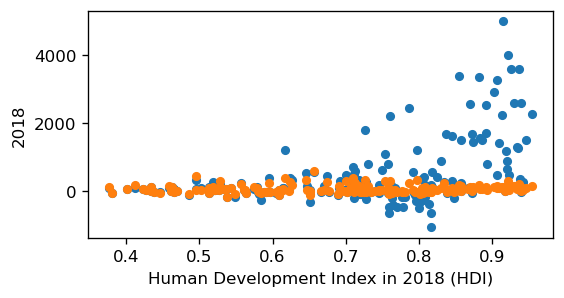

In [40]:
f, ax = plt.subplots()
ce_norm_65_df.plot.scatter('Human Development Index in 2018 (HDI)', 2018, ax=ax)

ce_norm_1_df.plot.scatter('Human Development Index in 2018 (HDI)', 2018, c='C1', ax=ax)

In [41]:
country_exposure_over65_absnorm

<xarray.Dataset>
Dimensions:               (country: 231, year: 41)
Coordinates:
  * country               (country) object 'AFG' 'ALB' 'DZA' ... 'YEM' 'ZMB'
  * year                  (year) int64 1980 1981 1982 1983 ... 2018 2019 2020
Data variables:
    heatwave_mean_length  (country, year) float64 -10.33 7.182 ... 40.3 -6.541
    heatwaves_counts      (country, year) float64 -6.273 -3.611 ... 41.49 31.82
    heatwaves_days        (country, year) float64 -43.87 -10.6 ... 267.0 133.3